In [184]:
# Hyperparameters
test_results = True
T = 15
N = 10
n_from_index = 0 # How distant the first point is
frame_rate = 10

In [185]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_trajectory, get_position, my_odometry


In [186]:
plt.rcParams['figure.figsize'] = [7, 7]

In [187]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [188]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)

In [189]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [190]:
dt = 1.0 / env.frame_rate

In [191]:
env.reset()
traj = get_trajectory(env, samples=500, method="distance", last_value_distance=1)

/home/giulio/prog/duckrace/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [192]:
pose = get_position(env)
pose

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

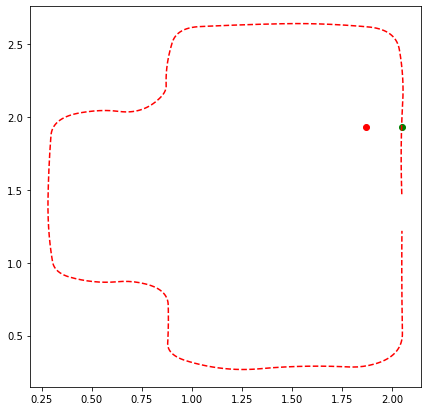

In [193]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [194]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 121.0'

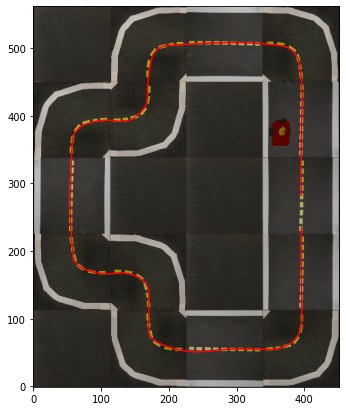

In [195]:
utils.show_on_map_array(env, traj[:,:2])

In [196]:
get_position(env)

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

In [197]:
# # Compute the angle between every consecutive points in traj
# angles = np.zeros(traj.shape[0])
# for i in range(traj.shape[0]-1):
#     angles[i] = np.arctan2(traj[i+1,1]-traj[i,1], traj[i+1,0]-traj[i,0])
# angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [198]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [199]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [200]:
# Drop values to fix weird final angle
# traj = traj[1:-1]

Plot angles:

If faces right red, else blue

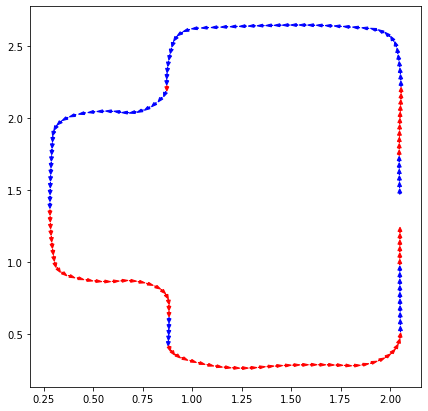

In [201]:
c="r"
for x, y, t in traj[::3]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [202]:
traj[index]

array([2.04861368, 1.93011832, 1.54824207])

In [203]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [204]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [205]:
pose = get_position(env)

DAE

In [206]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[1.872, 1.92971, 1.5708, 0.3, 0]


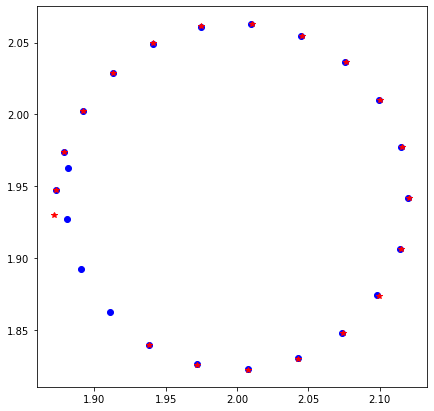

In [207]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [208]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [209]:
def mod(n, base):
    return n - floor(n/base) * base

In [210]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay

Q = opti.parameter(1)
Q2 = opti.parameter(1)
Q3 = opti.parameter(1)
R = opti.parameter(1)

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay

opti.set_value(Q, 100)
opti.set_value(Q2, 5e-4)
opti.set_value(Q3, 1)
opti.set_value(R, 1e-3)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()

In [211]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p, r, tr, u_delay, Q, Q2, Q3, R],[u[:,0]],['p', 'r', 'tr', 'u_delay', 'Q', 'Q2', 'Q3', 'R'],['u_opt'])

In [212]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0
errors = []
error_x = []
error_y = []
error_theta = []

kdtree = spatial.KDTree(traj[:, :2])

for i in range(450):
    u = M(x, r, tr, u_delay, 1e3, 1e-2, 1e-2, 1)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(distance)
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    r = traj[idx:idx+N+1, :2].T
    tr = traj[idx:idx+N+1, 2].T

In [213]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5128968344341883, max speed is 0.6'

In [214]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

'Mean error: 0.000510318276555747'

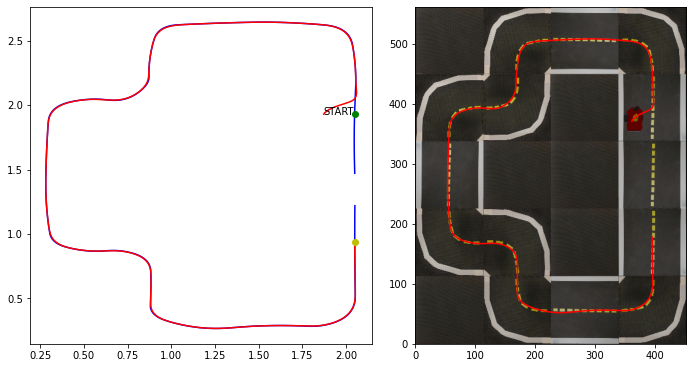

In [215]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

Text(0, 0.5, 'Distance from reference (m)')

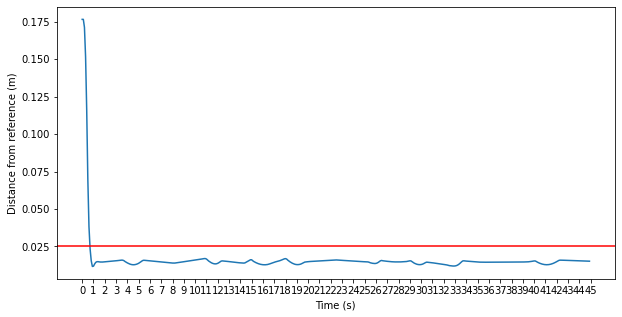

In [216]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, len(errors)*dt+1, 1.0))
plt.plot(np.arange(len(errors))*dt, np.sqrt(errors))
plt.axhline(y=0.025, color='r', linestyle='-')
plt.xlabel("Time (s)")
plt.ylabel("Distance from reference (m)")

Text(0.5, 0, 'Time (s)')

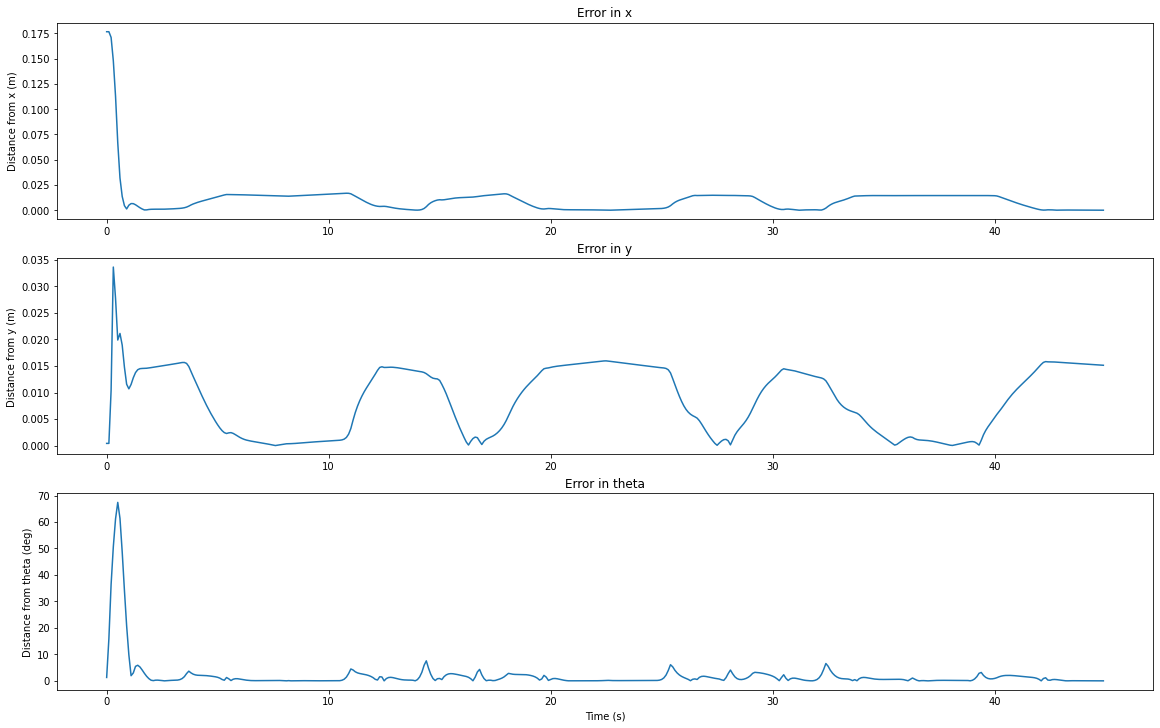

In [217]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

## Parameters sensitivity

### Multi parameter sensitivity

In [93]:
errors_Q = []

for Q_ in np.logspace(-4, 2, 20):
    errors_Q2 = []
    for Q2_ in np.logspace(-4, 2, 20):
        X_log = np.empty((5,0))
        U_log = np.empty((2,0))

        x = [pose.x, pose.y, pose.theta, 0, 0]
        r = r0
        tr = t0
        idx = index
        u_delay = u_delay0
        errors = []
        error_x = []
        error_y = []
        error_theta = []

        kdtree = spatial.KDTree(traj[:, :2])
        for i in range(50):
            u = M(x, r, tr, u_delay, Q_, Q2_, 1, 1)

            U_log = np.column_stack((U_log, u))
            X_log = np.column_stack((X_log, x))

            u_delay = np.column_stack((u_delay, u))[:, -delay:]

            # simulate
            x = F(x,u)

            distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
            errors.append(distance)
            error_x.append(traj[idx, 0] - x[0])
            error_y.append(traj[idx, 1] - x[1])
            error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

            _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
            r = traj[idx:idx+N+1, :2].T
            tr = traj[idx:idx+N+1, 2].T
        errors_Q2.append(np.array(errors).reshape(-1).sum())
    errors_Q.append(errors_Q2)

Text(0.5, 0.92, 'Q1 vs Q2')

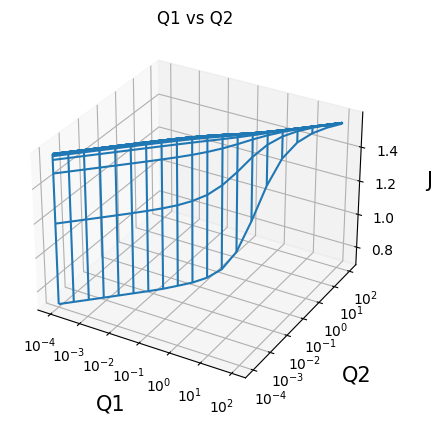

In [122]:
import matplotlib.ticker as mticker
import matplotlib as mpl

mpl.style.use("default")
ax = plt.axes(projection='3d')
ax.plot_wireframe(np.log10(np.logspace(-4, 2, 20)), np.log10(np.logspace(-4, 2, 20)), np.array(errors_Q), label="J")

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    #return f"{10**val:.2e}"      # e-Notation

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_xlabel('Q1', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('Q2', fontsize=15, labelpad=15)
ax.set_zlabel('J', fontsize=15, rotation=0, labelpad=10)
ax.yaxis.set_rotate_label(False)

ax.grid(True)

ax.set_title('Q1 vs Q2')

/tmp/ipykernel_5573/3905586947.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


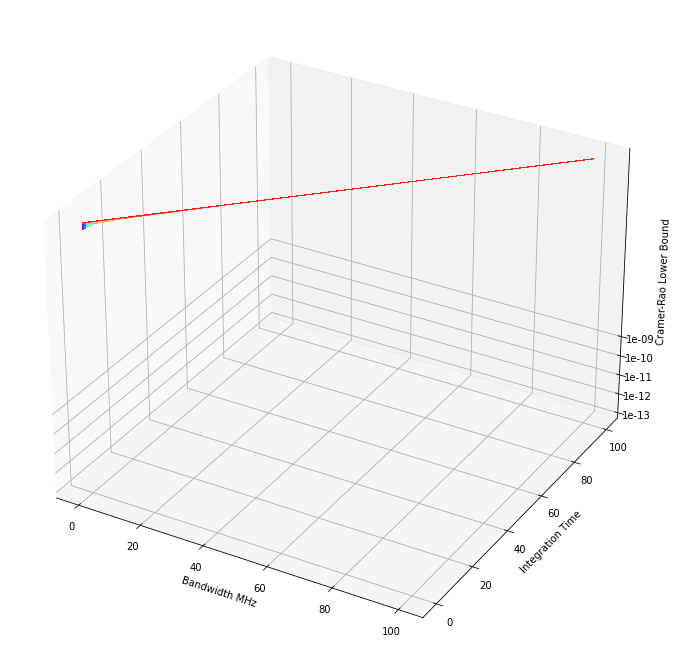

In [59]:
from mpl_toolkits.mplot3d import Axes3D

enablelog = True

snr=15
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

B = np.logspace(-3, 2, 10)
T = np.logspace(-3, 2, 10)
C = np.array(errors_Q)
if enablelog: C = np.log10(C)
surf = ax.plot_surface(
    B, T, C, cmap='rainbow',cstride=1,
    rstride=1,linewidth=0,antialiased=False)
ax.set_xlabel("Bandwidth MHz")
ax.set_ylabel("Integration Time")
ax.set_zlabel("Cramer-Rao Lower Bound")
if enablelog:zticks = [1e-13,1e-12,1e-11,1e-10,1e-9]
if enablelog:ax.set_zticks(np.log10(zticks))
if enablelog:ax.set_zticklabels(zticks)
plt.show()

#### Sensitivity to Q

In [34]:
errors_Q = []

for Q_ in np.logspace(-2, 3, 20):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []
    error_x = []
    error_y = []
    error_theta = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q_, 5e-4, 1, 1e-3)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)
        error_x.append(traj[idx, 0] - x[0])
        error_y.append(traj[idx, 1] - x[1])
        error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q.append(np.array(errors).reshape(-1).sum())

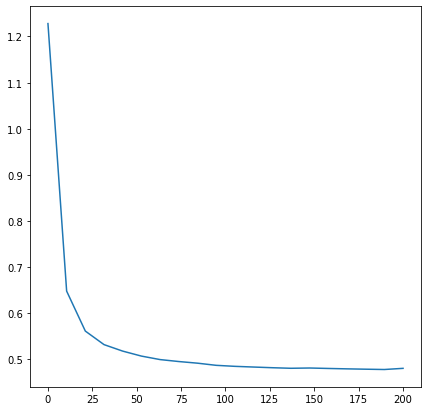

In [35]:
plt.plot(np.logspace(-2, 3, 20), errors_Q)

### Sensitivity to Q2

In [36]:
errors_Q2 = []

for Q2_ in np.logspace(-5, 0, 20):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 100, Q2_, 1, 1e-3)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q2.append(np.array(errors).reshape(-1).sum())

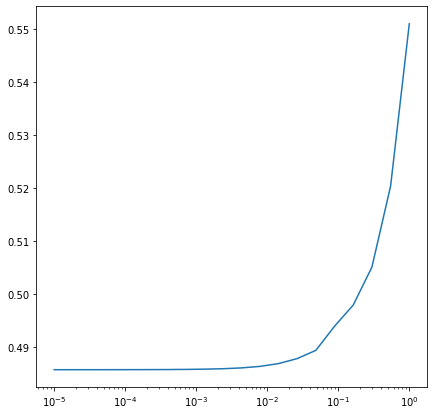

In [43]:
fig, ax = plt.subplots()
x = np.logspace(-5, 0, 20)
ax.plot(x, errors_Q2)

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q3

In [38]:
errors_Q3 = []

for Q3_ in np.logspace(-2, 2, 20):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 100, 5e-4, Q3_, 1e-3)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q3.append(np.array(errors).reshape(-1).sum())

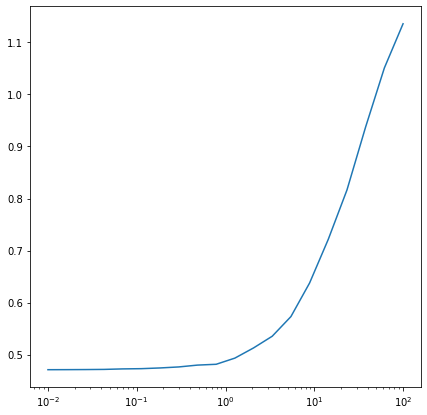

In [39]:
fig, ax = plt.subplots()
x = np.logspace(-2, 2, 20)
ax.plot(x, errors_Q3)

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to R

In [40]:
errors_R = []

for R_ in np.logspace(-4, 2, 20):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 100, 5e-4, 1, R_)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_R.append(np.array(errors).reshape(-1).sum())

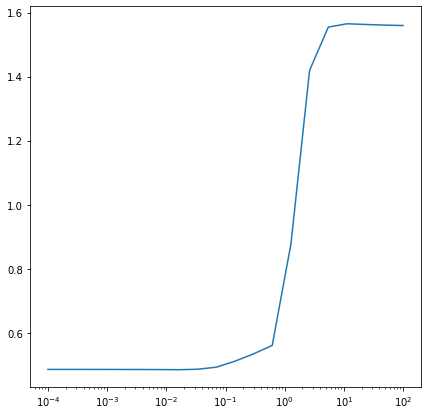

In [41]:
fig, ax = plt.subplots()
x = np.logspace(-4, 2, 20)
ax.plot(x, errors_R)

# Set x scale to logarithmic
ax.set_xscale('log')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [42]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x, r, tr, u_delay, 100, 5e-4, 1, 1e-3))
print(M2(x0, r0, t0, u_delay0, 100, 5e-4, 1, 1e-3))

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 0 (p) has mismatching shape. Got 20-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 5-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

### Gym simulation

The MPC does not consider the delay yet!

In [ ]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

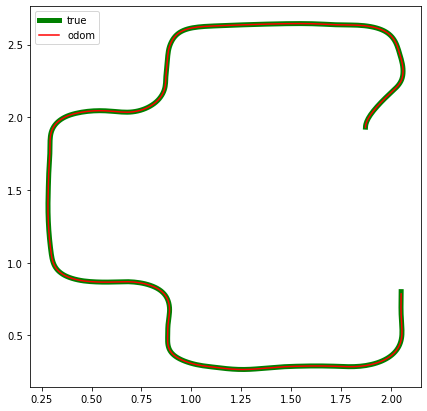

In [ ]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

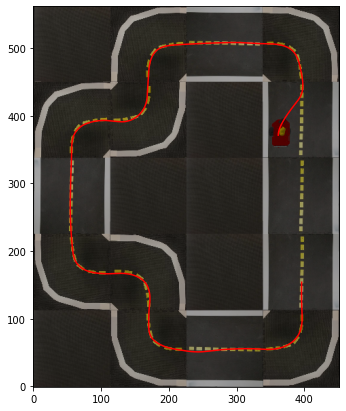

In [ ]:
if record:
    utils.show_on_map(env, positions)

In [ ]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))